In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator
from collections import defaultdict
import networkx as nx
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.circuit import ParameterVector, Parameter

# from qiskit_braket_provider import BraketProvider


In [2]:
service = QiskitRuntimeService()
backends = {}
# backends["ibm_fez"] = service.backend("ibm_fez", use_fractional_gates=True)
# backends["ibm_marrakesh"] = service.backend("ibm_marrakesh")
# backends["ibm_torino"] = service.backend("ibm_torino")
# backends["ibm_brisbane"] = service.backend("ibm_brisbane")
# backends["ibm_sherbrooke"] = service.backend("ibm_sherbrooke")
# backends["ibm_kyiv"] = service.backend("ibm_kyiv")
# backends["mps"] = service.backend("simulator_mps")
backends["qasm_simulator"] = QasmSimulator()



In [3]:
# service_braket = BraketProvider()
# backends["rigetti_ankaa_3"] = service_braket.get_backend("Ankaa-3")

# 1D-Chain list of qubits

List of qubits in the main 1D-Chain of IBM Eagle and Heron devices. In the main experiment, 100 qubits are used.

In [4]:
qubits_in_line = {}
# Eagle device
qubits_1D_Eagle = list(range(13,-1,-1)) + [14] + list(range(18,33)) + [36] + list(range(51,36,-1)) + [52] + list(range(56,71)) + [74] + list(range(89,74,-1)) + [90] + list(range(94,109)) + [112] + list(range(126,112,-1))

for backend in backends.keys():
    if backend[:3] == "ibm" and backend != "ibm_torino":
        qubits_in_line[backend] = qubits_1D_Eagle

# Heron device
qubits_in_line["ibm_torino"] = list(range(13,-1,-1)) + [15] + list(range(19,34)) + [37] + list(range(52,37,-1)) + [53] + list(range(57,72)) + [75] + list(range(90,75,-1)) + [91] + list(range(95,110)) + [113] + list(range(128,114,-1))
qubits_in_line["ibm_fez"] = list(range(0,16)) + [19] + list(range(35,20,-1)) + [36] + list(range(41,56)) + [59] + list(range(75,60,-1)) + [76] + list(range(81,96)) + [99] + list(range(115,100,-1)) + [116] + list(range(121,124))
qubits_in_line["ibm_marrakesh"] = qubits_in_line["ibm_fez"]

# Ankaa 2
qubits_in_line["ankaa_2"] = []
for i in range(7):
    if i%2:
        qubits_in_line["ankaa_2"]  += [i + j*7 for j in range(12)]
    else:
        qubits_in_line["ankaa_2"]  += [i + j*7 for j in reversed(range(12))]


In [5]:
problems = np.load("./Data/problems_1DChain.npy", allow_pickle=True).item()

# QAOA Circuit 

In [6]:
import json
problems = np.load("./Data/problems_1DChain.npy", allow_pickle=True).item()
all_dicts = {nq:{"problem":[(i,j,float(problems["G"][nq][i][j]["weight"]/2)) for i, j in problems["G"][nq].edges()],"sol":problems["sol"][nq][0]} for nq in problems["G"].keys()}
#with open("../metriq-gym/metriq_gym/data/lrqaoa_1d_data.json", "w") as f:
#    json.dump(all_dicts, f, indent=2)

In [7]:
import rustworkx as rx
G = nx.Graph()
G.add_weighted_edges_from(all_dicts[5]["problem"])

## LABS 

In [14]:
import math
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


# ----------------------------------------------------------------------
# Helper 1: build LABS Hamiltonian terms for arbitrary N
# ----------------------------------------------------------------------
def build_labs_terms(N):
    """
    Build the LABS Hamiltonian terms for sequence length N, using
    the form from Shaydulin et al. (Eq. 4), but in 0-based indexing.

    Returns:
        terms: list of (qubits, coeff)
            - qubits: tuple of logical qubit indices, e.g. (0, 2) or (0, 1, 2, 3)
            - coeff: float coefficient in front of Z⊗...⊗Z term
    """
    terms = []

    # 4-local terms: 2 * Z_i Z_{i+t} Z_{i+k} Z_{i+k+t}
    # paper: i = 1..N-3 (1-based), t = 1..floor((N-i-1)/2), k = t+1..N-i-t
    # here we convert to 0-based indices
    for i in range(1, N - 2 + 1):  # i in [1, N-2] (1-based)
        max_t = (N - i - 1) // 2
        for t in range(1, max_t + 1):
            for k in range(t + 1, N - i - t + 1):
                j0 = i - 1
                j1 = i + t - 1
                j2 = i + k - 1
                j3 = i + k + t - 1
                qubits = tuple(sorted([j0, j1, j2, j3]))
                terms.append((qubits, 2.0))  # coefficient 2 in Eq. (4)

    # 2-local terms: Z_i Z_{i+2k}
    # paper: i = 1..N-2, k = 1..floor((N-i)/2)
    for i in range(1, N - 1 + 1):  # i in [1, N-1]
        max_k = (N - i) // 2
        for k in range(1, max_k + 1):
            j0 = i - 1
            j1 = i + 2 * k - 1
            qubits = tuple(sorted([j0, j1]))
            terms.append((qubits, 1.0))  # coefficient 1 in Eq. (4)

    # (Constant offset in Esidelobe is dropped → only a global phase)
    # Deduplicate any accidental duplicates (shouldn't really happen, but just in case)
    unique_terms = {}
    for qubits, coeff in terms:
        unique_terms[qubits] = unique_terms.get(qubits, 0.0) + coeff

    return [(q, c) for q, c in unique_terms.items() if abs(c) > 1e-12]


# ----------------------------------------------------------------------
# Helper 2: apply exp(-i * gamma * coeff * Z⊗...⊗Z) for a given term
# ----------------------------------------------------------------------
def _apply_parity_phase(qc: QuantumCircuit, physical_qubits, gamma: float, coeff: float):
    """
    Apply U = exp(-i * gamma * coeff * Z⊗...⊗Z) on the given *physical* qubits
    using a CNOT ladder into the last qubit, then RZ, then uncompute.

    Args:
        qc: QuantumCircuit
        physical_qubits: list/tuple of physical qubit indices in the circuit
        gamma: QAOA parameter γ_p
        coeff: Hamiltonian coefficient (e.g. 1.0 or 2.0)
    """
    physical_qubits = list(physical_qubits)

    if len(physical_qubits) == 1:
        # 1-local: just an RZ on that qubit
        target = physical_qubits[0]
        qc.rz(2.0 * gamma * coeff, target)
        return

    target = physical_qubits[-1]
    controls = physical_qubits[:-1]

    # Compute parity of controls into target
    for q in controls:
        qc.cx(q, target)

    # RZ(2 * gamma * coeff) implements exp(-i * gamma * coeff * Z_target)
    # which, given the parity encoding, equals exp(-i * gamma * coeff * Z_prod)
    qc.rz(2.0 * gamma * coeff, target)

    # Uncompute parity
    for q in reversed(controls):
        qc.cx(q, target)


# ----------------------------------------------------------------------
# Helper 3: one LABS cost layer e^{-i gamma H_C} for arbitrary N
# ----------------------------------------------------------------------
def labs_cost_layer(qc: QuantumCircuit, gamma, labs_terms, logical_to_physical=None):
    """
    Apply one LABS phase separator layer e^{-i gamma H_C}.

    Args:
        qc: QuantumCircuit
        gamma: scalar or Parameter (e.g. gammas[p])
        labs_terms: list of (qubits, coeff) in logical indices 0..N-1
        logical_to_physical: list mapping logical index -> physical qubit in the circuit.
                             If None, assume logical index == physical index.
    """
    if logical_to_physical is None:
        logical_to_physical = list(range(qc.num_qubits))

    for logical_qubits, coeff in labs_terms:
        physical_qubits = [logical_to_physical[q] for q in logical_qubits]
        _apply_parity_phase(qc, physical_qubits, gamma, coeff)


# ----------------------------------------------------------------------
# Main: QAOA for LABS on IBM-style hardware
# ----------------------------------------------------------------------
def labs_qaoa_ibm(N, layers, max_nq, qubits_in_line=None):
    """
    Construct a QAOA circuit for the LABS problem of sequence length N.

    Args:
        N (int): LABS sequence length (number of logical qubits).
        layers (int): Number of QAOA layers (p).
        max_nq (int): Total number of physical qubits in the circuit.
                      Must satisfy max_nq >= N if using the first N in a line.
        qubits_in_line (list[int], optional):
            A list specifying the physical qubit order/topology (e.g. a linear chain).
            The first N entries will be used for the LABS instance.
            If None, we assume logical qubit i maps to physical qubit i.

    Returns:
        QuantumCircuit: QAOA circuit for LABS with N logical qubits.
    """
    if max_nq < N:
        raise ValueError(f"max_nq ({max_nq}) must be >= N ({N}).")

    if qubits_in_line is None:
        qubits_in_line = list(range(max_nq))

    # Logical qubits 0..N-1 mapped onto the first N entries of qubits_in_line
    logical_qubits = list(range(N))
    logical_to_physical = qubits_in_line[:N]

    # Parameter vectors
    betas = ParameterVector("betas", layers)
    gammas = ParameterVector("gammas", layers)

    # Precompute LABS Hamiltonian terms in logical indices
    labs_terms = build_labs_terms(N)

    # Build circuit: max_nq physical qubits, N classical bits
    qc = QuantumCircuit(max_nq, N)

    # Initial state: |+>^{⊗N} on the logical qubits
    qc.h(logical_to_physical)

    # QAOA layers
    for p in range(layers):
        # Cost layer: e^{-i gamma_p H_C}
        labs_cost_layer(qc, gammas[p], labs_terms, logical_to_physical)

        # Mixer layer: RX(-2 * beta_p) on each logical qubit
        for phys_q in logical_to_physical:
            qc.rx(-2.0 * betas[p], phys_q)

    # Measure logical qubits into classical bits 0..N-1
    qc.measure(logical_to_physical, list(range(N)))

    return qc


In [15]:
build_labs_terms(4)

[((0, 1, 2, 3), 2.0), ((0, 2), 1.0), ((1, 3), 1.0)]

In [24]:
N=4
layers=2
max_nq=4
qc=labs_qaoa_ibm(N, layers, max_nq, qubits_in_line=None)

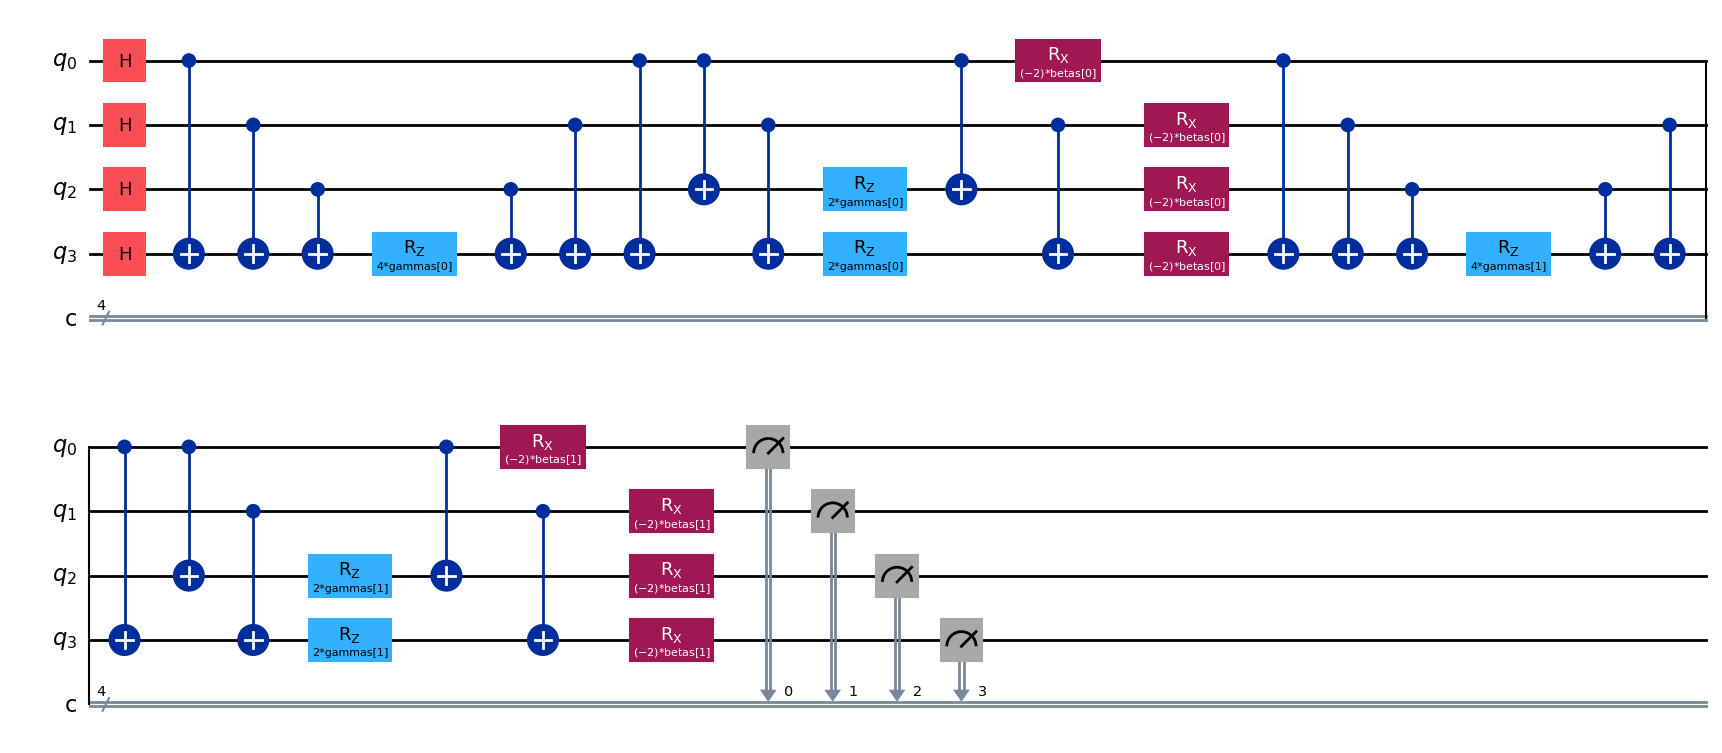

In [25]:
qc.draw('mpl')

## WMC

In [11]:
def maxcut_qaoa_ibm(GT, layers, max_nq, qubits_in_line, fractional_gates=True):
    """
    Constructs a QAOA (Quantum Approximate Optimization Algorithm) circuit for solving the Max-Cut problem 
    on a given weighted graph using IBM quantum hardware constraints.

    Parameters:
    GT (networkx.Graph): The input weighted graph where edge weights represent the cost of a cut.
    layers (int): Number of QAOA layers (depth of the circuit).
    max_nq (int): Maximum number of qubits available for computation.
    qubits_in_line (list): A list specifying the qubit topology (linear connectivity).
    fractional_gates (bool, optional): If True, uses RZZ gates for optimization. 
                                       If False, decomposes RZZ into CX and RZ gates. 
                                       Default is True (preferred for IBM quantum processors).

    Returns:
    QuantumCircuit: A quantum circuit implementing the QAOA Max-Cut algorithm.
    """

    # Define parameter vectors for optimization angles
    betas = ParameterVector("betas", layers)  # Mixing layer rotation angles
    gammas = ParameterVector("gamma", layers)  # Phase-separating layer angles

    # Define two alternating layers for edge connections in a linear qubit topology
    layer_1 = [[qubits_in_line[i], qubits_in_line[i+1]] for i in range(0, len(qubits_in_line)-1, 2)]
    layer_2 = [[qubits_in_line[i], qubits_in_line[i+1]] for i in range(1, len(qubits_in_line)-1, 2)]
    
    # Get the number of nodes in the graph
    nodes = GT.number_of_nodes()
    
    # Find the maximum absolute edge weight in the graph for normalization
    max_weight = np.max(np.abs([GT[i][j]["weight"] for i, j in GT.edges()]))
    
    # Initialize the quantum circuit with max_nq qubits and classical bits for measurement
    qc = QuantumCircuit(max_nq, nodes)
    
    # Get a list of graph nodes
    nodes_list = list(GT.nodes)
    
    # Apply Hadamard gates to all qubits to create an equal superposition state
    qc.h(nodes_list)

    # Apply QAOA layers
    for p in range(layers):
        # Apply phase-separating unitaries using the problem Hamiltonian
        for i, j in GT.edges():
            w = GT[i][j]["weight"]  # Get edge weight
            qbits = [i, j]
            
            # Apply controlled phase shift on layer 1 edges
            if (sorted(qbits) in layer_1 or qbits in layer_1) and abs(w) > 1e-6:
                if fractional_gates:
                    # Use native RZZ gate for more efficient execution on IBM hardware
                    qc.rzz(2 * gammas[p] * GT[i][j]["weight"] / max_weight, *qbits)
                else:
                    # Decomposed version using CX and RZ gates
                    qc.cx(*qbits)
                    qc.rz(2 * gammas[p] * GT[i][j]["weight"] / max_weight, j)
                    qc.cx(*qbits)

        # Apply controlled phase shift on layer 2 edges
        for i, j in GT.edges():
            w = GT[i][j]["weight"]
            qbits = [i, j]
            
            if (sorted(qbits) in layer_2 or qbits in layer_2) and abs(w) > 1e-6:
                if fractional_gates:
                    # Use native RZZ gate if allowed
                    qc.rzz(2 * gammas[p] * GT[i][j]["weight"] / max_weight, *qbits)
                else:
                    # Decomposed implementation
                    qc.cx(*qbits)
                    qc.rz(2 * gammas[p] * GT[i][j]["weight"] / max_weight, j)
                    qc.cx(*qbits)

        # Apply mixing layer with RX rotations to all qubits
        qc.rx(-2 * betas[p], nodes_list)

    # Measure all qubits and store results in classical bits
    qc.measure(nodes_list, range(nodes))

    return qc  # Return the constructed QAOA circuit

def repeat_subgraph(G, qubits_line):
    """
    Repeats a given subgraph structure multiple times across a list of qubits.

    Parameters:
    G (networkx.Graph): The base subgraph to be repeated.
    qubits_line (list): A list of qubit indices where the repeated graph structure will be mapped.

    Returns:
    networkx.Graph: A new graph GT with the repeated subgraph structure.
    """

    n_qubits = G.number_of_nodes()  # Number of nodes in the base subgraph
    n_reps = len(qubits_line) // n_qubits  # Determine how many times the subgraph is repeated

    GT = nx.Graph()  # Create an empty graph
    GT.add_nodes_from(qubits_line[:n_reps * n_qubits])  # Add nodes to GT based on qubits_line

    # Iterate over repetitions and copy edges with weights
    for rep in range(n_reps):
        for i, j in G.edges:
            w = G[i][j]["weight"]  # Extract edge weight
            # Map original nodes to repeated positions and add weighted edges
            GT.add_weighted_edges_from([[qubits_line[i + rep * n_qubits], qubits_line[j + rep * n_qubits], w]])

    return GT  # Return the expanded graph with repeated subgraphs

# Objective Function

In [12]:
def cost_maxcut(bitstring, weights):
    """
    Computes the cost of a given bitstring solution for the Max-Cut problem.

    Parameters:
    bitstring (str): A binary string representing a partition of the graph nodes (e.g., "1010").
    weights (dict): A dictionary where keys are edge tuples (i, j) and values are edge weights.

    Returns:
    float: The computed cost of the Max-Cut solution.
    """
    cost = 0  # Initialize the cost
    
    # Iterate through all edges in the graph
    for i, j in weights.keys():
        # Check if the nodes i and j are in different partitions (cut condition)
        if bitstring[i] + bitstring[j] in ["10", "01"]:
            cost += weights[i, j]  # Add the edge weight to the cost

    return cost  # Return the total cut cost


def objective_MaxCut(samples_dict, G, optimal):
    """
    Evaluates the performance of a quantum algorithm for the Max-Cut problem.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    optimal (str): The optimal bitstring solution found by classical solvers (e.g., CPLEX).

    Returns:
    dict: A dictionary containing:
        - "results": A numpy array with computed cost, normalized cost ratio, and counts.
        - "G": The input graph G.
        - "weights": The edge weights extracted from G.
        - "max_cut": The cost of the optimal Max-Cut solution.
        - "r": The expected approximation ratio.
        - "probability": The probability of sampling the optimal solution.
    """

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    
    # Compute the cost of the optimal Max-Cut solution
    max_cost = cost_maxcut(optimal, weights)

    results = []  # Stores results in the form [cost, ratio, counts]
    probability = 0  # Tracks probability of sampling the optimal solution

    # Iterate through all sampled bitstrings
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, weights)  # Compute cost of the given bitstring
        r = cost / max_cost  # Compute the cost ratio relative to the optimal solution
        results.append([cost, r, counts])  # Store results
        
        # If this bitstring matches the optimal cost, update probability
        if abs(cost - max_cost) < 1e-6:
            probability += counts
        
        # Check if a better-than-optimal solution appears (sanity check)
        if cost > max_cost:
            print(f"There is a better cost than that of CPLEX: {cost - max_cost}")

    # Convert results to a NumPy array for easy computation
    results = np.array(results)

    # Total number of shots (total sampled solutions)
    shots = np.sum(results[:, 2])

    # Compute the expected approximation ratio: (weighted sum of costs) / (shots * max_cost)
    rT = np.sum(results[:, 0] * results[:, 2]) / (shots * max_cost)

    # Normalize the probability of sampling the optimal solution
    probability /= shots

    # Return results in a structured dictionary
    return {
        "results": np.array(results),
        "G": G,
        "weights": weights,
        "max_cut": max_cost,
        "r": rT,
        "probability": probability
    }

def mitigate(samples_dict, G, random=False):
    """
    Applies error mitigation by flipping individual bits in sampled solutions 
    to find better Max-Cut solutions.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    random (bool, optional): If True, randomizes the order in which qubits are flipped.
                             Default is False (systematic flipping).

    Returns:
    dict: A dictionary of improved bitstring samples with their updated counts.
    """

    # Define a mapping to flip bits ('0' -> '1', '1' -> '0')
    change = {"0": "1", "1": "0"}

    # Get the number of nodes (qubits)
    nq = G.number_of_nodes()

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}

    # Dictionary to store new (improved) samples
    new_samples = defaultdict(int)

    # Iterate over all bitstring samples
    for bitstring, counts in samples_dict.items():
        for _ in range(counts):  # Process each occurrence of the bitstring separately
            best_string = bitstring  # Initialize the best solution as the current one
            best_cost = cost_maxcut(bitstring, weights)  # Compute its cost
            
            # Create an ordered list of qubits (nodes) to consider flipping
            list_qubits = np.arange(nq)
            
            # If random flipping is enabled, shuffle the qubit order
            if random:
                np.random.shuffle(list_qubits)

            # Try flipping each qubit and check if the cost improves
            for qi in list_qubits:
                # Flip the bit at position qi
                new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                new_cost = cost_maxcut(new_string, weights)

                # If the new configuration gives a better cost, update the best solution
                if new_cost > best_cost:
                    best_string = new_string
                    best_cost = new_cost
            
            # Store the improved bitstring in the new_samples dictionary
            new_samples[best_string] += 1

    return new_samples  # Return the mitigated samples

def random_samples(num_samples, n_qubits):
    """
    Generates random bitstring samples for a given number of qubits.

    Parameters:
    num_samples (int): The number of random bitstrings to generate.
    n_qubits (int): The number of qubits (length of each bitstring).

    Returns:
    dict: A dictionary where keys are randomly generated bitstrings 
          and values are their occurrence counts.
    """
    
    random_samples = defaultdict(int)  # Dictionary to store bitstrings and their counts

    # Generate random bitstrings and count their occurrences
    for _ in range(num_samples):
        bitstring = "".join(str(i) for i in np.random.choice([0, 1], n_qubits))  # Generate a random bitstring
        random_samples[bitstring] += 1  # Increment count for the generated bitstring

    return random_samples  # Return the dictionary of samples


# 1) IBM Eagle and Heron: Prepare the experiments

In [17]:
#jm
labs_flag=True
N=4
# Select the backend for quantum computation
# Uncomment the desired backend or set the active one
# backend_name = "ibm_brisbane"
# backend_name = "ibm_sherbrooke"
# backend_name = "ibm_kyiv"
# backend_name = "ibm_nazca"
# backend_name = "ibm_osaka"
# backend_name = "ibm_kyoto"
# backend_name = "ibm_torino"
# backend_name = "ibm_fez"  # Active backend
# backend_name = "ibm_marrakesh"
# backend_name = "ibm_strasbourg"
# backend_name = "ibm_brussels"
# backend_name = "ankaa_2"
backend_name = "qasm_simulator"  # Classical simulator option

results = {}  # Dictionary to store experiment results

# ---------------------- Loading Problem Information ----------------------
# jm
nq =5 # 30 # 100  # Number of qubits (size of the problem)

# Define qubit mappings for different backends
qubits_in_line["qasm_simulator"] = range(nq)  # Simulator uses a linear qubit range

# Load the problem graph
results["G"] = problems["G"][nq]  

# Repeat subgraph structure to match the qubit layout of the chosen backend
results["GT"] = repeat_subgraph(results["G"], qubits_in_line[backend_name])

# Select the graph to use: 
# If using a real quantum backend, use the transformed graph (GT), 
# otherwise use the original problem graph (G) for the simulator
GT = results["GT"] if backend_name != "qasm_simulator" else results["G"]
print('using graph with ', GT.number_of_nodes(), ' nodes and ', GT.number_of_edges(), ' edges')
# Load optimal solutions for the given problem size
sols = problems["sol"][nq]  

# Get the list of qubits assigned for the selected backend
qubits_line = qubits_in_line[backend_name]

# Get the maximum number of qubits available on the backend
max_nq = backends[backend_name].num_qubits  

# ---------------------- QAOA Configuration ----------------------

# Define the number of QAOA layers
#ps = [3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 40, 50, 75, 100]  
#jm
ps = [3] #, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 40, 50, 75, 100]  
# ps = [10_000]  # Set a single large QAOA depth for testing

# Define delta values for parameter scaling
# deltas = np.linspace(0.5, 1.5, 10)  # Generate 10 values between 0.5 and 1.5
deltas = [0.75]  # Set a single delta value for testing

# Store key experiment parameters in results
results["optimal"] = sols  
results["nq"] = nq  
results["ps"] = ps  
results["Deltas"] = deltas  

# ---------------------- Circuit Compilation ----------------------

circuits_transpiled = {}  # Store transpiled circuits for different QAOA layers

# Iterate over different QAOA layers
for p in ps:
    print(f"Layer: -------  {p} ----------- ")  # Display current layer
    if labs_flag:
      layers=p
      circ_maxcut = labs_qaoa_ibm(N, layers, max_nq, qubits_in_line=None)
    else: 
      # Generate the QAOA circuit for MaxCut problem
      circ_maxcut = maxcut_qaoa_ibm(GT, p, max_nq, qubits_line, fractional_gates=True)
    
    # Transpile the circuit for the selected backend
    # Optimization level 1 applies basic circuit optimizations while preserving logical structure
    backend_circ = transpile(circ_maxcut, backend=backends[backend_name], optimization_level=1, initial_layout=range(max_nq))
    
    # Store the transpiled circuit
    circuits_transpiled[p] = backend_circ  

# ---------------------- Assigning Parameters & Executing Circuits ----------------------

circuits = []  # Store final circuits with assigned parameters

# Iterate over different delta values
for delta in deltas:
    print(f"Delta: -------  {round(delta,2)} ----------- ")  # Display current delta value
    
    for p in ps:
        # Compute beta and gamma parameters for QAOA
        betas = list(np.arange(1, p+1)[::-1] * delta/p)  # Reverse sequence for betas
        gammas = list(np.arange(1, p+1) * delta/p)  # Forward sequence for gammas
        
        # Assign the computed parameters to the transpiled circuit
        backend_circ = circuits_transpiled[p].assign_parameters(np.concatenate((betas, gammas)))
        
        # Store the final circuit
        circuits.append(backend_circ)  


using graph with  5  nodes and  4  edges
Layer: -------  3 ----------- 
Delta: -------  0.75 ----------- 


# 2) IBM Eagle and Heron: Run the experiments

In [18]:
#stop

In [21]:
#jm
circuits=circuits[:1]

In [22]:
#shots = 1_000  # Number of measurement shots per circuit execution
#jm
shots = 1#_000  # Number of measurement shots per circuit execution
extra = ""  # Additional identifier for file naming (indicating 10,000 QAOA layers)
# extra = ""  # Uncomment this line if no extra identifier is needed
results["shots"] = shots  

# Check if using a real quantum backend (not the classical simulator)
if backend_name != "qasm_simulator":
    # Initialize a sampler for running the circuits on a real quantum device
    sampler = Sampler(mode=backends[backend_name])
    
    # Submit the circuits for execution with the specified number of shots
    submit_job = sampler.run(circuits, shots=shots)
    
    # Store the job ID to track or retrieve results later
    results["id"] = submit_job.job_id()  
    
    # Alternative way to submit the job directly to the backend
    # submit_job = backends[backend_name].run(circuits, shots=shots)
    # results["id"] = submit_job.job_id()  # Save job ID for retrieval

else:
    print('running with backend_name: ', backend_name)
    # If using the qasm_simulator (classical simulator), execute the circuits directly
    dict_results = backends[backend_name].run(circuits, shots=shots).result().get_counts()
    
    # Process the results:
    # - Reverse bitstrings (to match standard qubit ordering)
    # - Organize results into a nested dictionary: {delta -> {p -> {bitstring -> counts}}}
    results["samples"] = {
        delta: {
            p: {k[::-1]: v for k, v in dict_results[i + nd * len(ps)].items()} 
            for i, p in enumerate(results["ps"])
        } 
        for nd, delta in enumerate(results["Deltas"])
    }

# Save results as a NumPy binary file for further analysis
np.save(f"./Data/{backend_name}/{nq}_1D{extra}.npy", results)  


running with backend_name:  qasm_simulator


KeyError: 0

In [ ]:
results

{'G': <networkx.classes.graph.Graph at 0x137de4440>,
 'GT': <networkx.classes.graph.Graph at 0x15d6b0650>,
 'optimal': ['101010101010101010101010101010',
  '010101010101010101010101010101'],
 'nq': 30,
 'ps': [3],
 'Deltas': [0.75],
 'shots': 1}

# Retrieve the experimental information

In [ ]:
#backend_name = "ibm_fez"  # Define the IBM backend used for execution
#jm
backend_name='qasm_simulator'

# Specify additional identifier for file naming:
extra = ""  # No extra identifier

nq = 100  # Number of qubits

# Load the previously saved results from a NumPy binary file
results = np.load(f"./Data/{backend_name}/{nq}_1D{extra}.npy", allow_pickle=True).item()

# If using a real quantum device, retrieve job results from IBM Quantum service
if backend_name != "qasm_simulator":
    # Fetch the job results using its stored job ID
    job = service.job(job_id=results["id"]).result()

    # Extract bitstring measurement results from all circuits in the job
    dict_results = [job[i].data.c.get_counts() for i in range(len(job))]

    # Process and store results:
    # - Reverse bitstrings (`k[::-1]`) to match standard qubit ordering.
    # - Organize results into a nested dictionary: {delta -> {p -> {bitstring -> counts}}}.
    results["samples"] = {
        delta: {
            p: {k[::-1]: v for k, v in dict_results[i + nd * len(ps)].items()}
            for i, p in enumerate(results["ps"])
        }
        for nd, delta in enumerate(results["Deltas"])
    }


# Postprocessing the samples

In [ ]:
# Extract the number of nodes (qubits) in the original and repeated graph
nq = results["G"].number_of_nodes()  # Number of qubits in the original problem graph
nq_total = results["GT"].number_of_nodes()  # Number of qubits in the repeated subgraph
sections = nq_total // nq  # Number of repeated sections in the larger subgraph

# Dictionaries to store post-processing results
postprocessing = {}
postprocessing_mitig = {}

# Iterate over different values of delta (hyperparameter for QAOA)
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}

    # Iterate over different QAOA layer depths (p)
    for p in results["samples"][delta]:
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}

        # Iterate over each section of the repeated subgraph
        for sec in range(sections):
            samples_sec = defaultdict(int)

            # Extract samples corresponding to the current section
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec * nq : (sec + 1) * nq]] += v

            # Compute objective function for the MaxCut problem
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"][0])

            # Apply error mitigation (local search improvement)
            new_samples = mitigate(samples_sec, results["G"], random=False)

            # Compute the objective function for mitigated results
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"][0])

# Store the post-processed and mitigated results
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

# Generate random bitstring samples for comparison
rand_samples = random_samples(10_000, nq)

# Compute the objective function for random sampling (baseline performance)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"][0])

# Apply error mitigation to random samples and evaluate performance
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"][0])

# Save the updated results dictionary
np.save(f"./Data/{backend_name}/{nq}_1D{extra}.npy", results)


----------- p = 10000 -------------


# AWS experiments

In [ ]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import Devices, LocalSimulator
from braket.circuits import Circuit

In [ ]:
backends = {}
backends["iqm_garnet"] = AwsDevice(Devices.IQM.Garnet)
backends["rigetti_ankaa_3"] = AwsDevice(Devices.Rigetti.Ankaa3)
backends["local_simulator"] = LocalSimulator()



In [ ]:
G = backends["rigetti_ankaa_3"].topology_graph
path = [0]
while True:
    neighbor_qubits = list(G[path[-1]].keys())
    suma = 0
    for q in neighbor_qubits:
        if q not in path and q not in [35,55]:
            path.append(q)
            break
        else:
            suma += 1
    if suma == len(neighbor_qubits):
        break
    
qubits_in_line = {"rigetti_ankaa_3":path, "iqm_garnet":[2, 3, 0, 1, 4, 5, 6, 11, 10, 9, 8, 7, 12, 13, 14, 15, 19, 18, 17]}

In [ ]:
def qaoa_maxcut_aws_sorted(gammas, betas, G, qubits_in_line):
    nq = G.number_of_nodes()
    p = len(gammas) 
    nodes = G.nodes()
    weights = [G[i][j]["weight"] for i,j in G.edges()]
    max_weight = max(weights)
    qc = Circuit()
    qc.h(nodes)
    layers = [[(qubits_in_line[i],qubits_in_line[i+1]) for i in range(j, nq-1, 2)] for j in range(2)]
    for pi in range(p):
        for layer in layers:
            for i, j in G.edges():
                if (i,j) in layer or (j,i) in layer:
                    qc.cnot(i, j)
                    qc.rz(j, 2 * gammas[pi] * G[i][j]["weight"]/max_weight)
                    qc.cnot(i, j)
        qc.rx(nodes, -2 * betas[pi])
    return qc

In [ ]:
problems = np.load("./Data/problems_1DChain.npy", allow_pickle=True).item()

In [ ]:
# Select the backend for quantum computation
# Uncomment the desired backend or set the active one
backend_name = "rigetti_ankaa_3"  # Active backend
# backend_name = "iqm_garnet"  # Active backend
# backend_name = "local_simulator"
extra = ""
results = {}  # Dictionary to store experiment results

# ---------------------- Loading Problem Information ----------------------

nq = 10  # Number of qubits (size of the problem)

# Load the problem graph
results["G"] = problems["G"][nq]  

qubits_in_line["local_simulator"] = [3,5,4,2,1,6,7]
if extra == "single":   
    qubits_used = list(range(nq))
else: 
    qubits_used = qubits_in_line[backend_name]

# Repeat subgraph structure to match the qubit layout of the chosen backend
results["GT"] = repeat_subgraph(results["G"], qubits_used)

# Select the graph to use: 
# If using a real quantum backend, use the transformed graph (GT), 
# otherwise use the original problem graph (G) for the simulator
GT = results["GT"] if backend_name != "qasm_simulator" else results["G"]

# Load optimal solutions for the given problem size
sols = problems["sol"][nq]  

# Get the maximum number of qubits used on the backend
max_nq = len(qubits_used)

# ---------------------- QAOA Configuration ----------------------

# Define the number of QAOA layers
# ps = [3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 40, 50, 75, 100] 
ps = [3, 4, 5, 6, 7, 8, 9, 10]  
 
# ps = [3]  

# ps = [10_000]  # Set a single large QAOA depth for testing

# Define delta values for parameter scaling
# deltas = np.linspace(0.5, 1.5, 10)  # Generate 10 values between 0.5 and 1.5
deltas = [1]  # Set a single delta value for testing

# Store key experiment parameters in results
results["optimal"] = sols  
results["nq"] = nq  
results["ps"] = ps  
results["Deltas"] = deltas  

# ---------------------- Circuit Compilation ----------------------

circuits = []
# Iterate over different QAOA layers
for delta in deltas:
    print(f"Delta: -------  {round(delta,2)} ----------- ")  # Display current delta value
    for p in ps:
        print(f"Layer: -------  {p} ----------- ")  # Display current layer
        
        betas = list(np.arange(1, p+1)[::-1] * delta/p)  # Reverse sequence for betas
        gammas = list(np.arange(1, p+1) * delta/p)  # Forward sequence for gammas
        # Generate the QAOA circuit for MaxCut problem
        circ_maxcut = qaoa_maxcut_aws_sorted(gammas, betas, GT, qubits_used)
        # Store the transpiled circuit  
        circuits.append(circ_maxcut) 
         


Delta: -------  1 ----------- 
Layer: -------  3 ----------- 
Layer: -------  4 ----------- 
Layer: -------  5 ----------- 
Layer: -------  6 ----------- 
Layer: -------  7 ----------- 
Layer: -------  8 ----------- 
Layer: -------  9 ----------- 
Layer: -------  10 ----------- 
Layer: -------  13 ----------- 
Layer: -------  15 ----------- 
Layer: -------  20 ----------- 


In [ ]:
# sorted_qubits = np.argsort(list(results["GT"].nodes()))
# qubits_dict = {j:i for i,j in enumerate(sorted_qubits)}
# samples = backends["local_simulator"].run(circuits[-1], shots=100).result().measurement_counts
# print({"".join(k[qubits_dict[ii]] for ii in results["GT"].nodes()):v for k, v in dict(samples).items()})

{'10101': 50, '01010': 50}


The p = 100 and Nq = 10 produced an error "Compilation timed out or produced an error. Please reach out to AWS Customer Support for support."

In [ ]:
shots = 1_000

results["shots"] = shots
ids = {}
for i in range(len(circuits)):
# run circuit
    task = backends[backend_name].run(circuits[i], shots=shots, disable_qubit_rewiring=True)
    ids[ps[i]] = task.id
    # get id and status of submitted quantum task

    status = task.state()
    # print('ID of quantum task:', iqm_task_id)
    print('Status of quantum task:', status)
results["ids"] = ids
np.save(f"./Data/{backend_name}/{nq}_1D{extra}.npy", results)

Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED


In [ ]:
# backend_name = "iqm_garnet"
backend_name = "rigetti_ankaa_3"
extra = ""
nq = 5
results = np.load(f"./Data/{backend_name}/{nq}_1D{extra}.npy", allow_pickle=True).item()
results["ps"] = results["ps"][:8]
dict_results = [AwsQuantumTask(arn=results["ids"][p]).result().measurement_counts for p in results["ps"]]
sort_bitstrings = results["GT"].nodes()

qubits_dict = {j:i for i,j in enumerate(results["GT"].nodes())}
results["samples"] = {delta:{p:{"".join(k[qubits_dict[ii]] for ii in results["GT"].nodes()):v for k, v in dict_results[i+nd*len(results["ps"])].items()} for i, p in enumerate(results["ps"])} for nd, delta in enumerate(results["Deltas"])}

In [ ]:
results["ps"] = results["ps"][:8]
nq = results["G"].number_of_nodes()
nq_total = results["GT"].number_of_nodes()
sections = nq_total // nq
results["sections"]  = sections
postprocessing = {}
postprocessing_mitig = {}
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    for p in results["samples"][delta]:
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}
        for sec in range(sections):
            samples_sec = defaultdict(int)
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec*nq:(sec+1)*nq]] += v
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"][0])
            new_samples = mitigate(samples_sec, results["G"], random=False)
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"][0])
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

rand_samples = random_samples(10000, nq)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"][0])
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"][0])

np.save(f"./Data/{backend_name}/{nq}_1D{extra}.npy", results)

----------- p = 3 -------------
----------- p = 4 -------------
----------- p = 5 -------------
----------- p = 6 -------------
----------- p = 7 -------------
----------- p = 8 -------------
----------- p = 9 -------------
----------- p = 10 -------------


Text(0.5, 0, 'p')

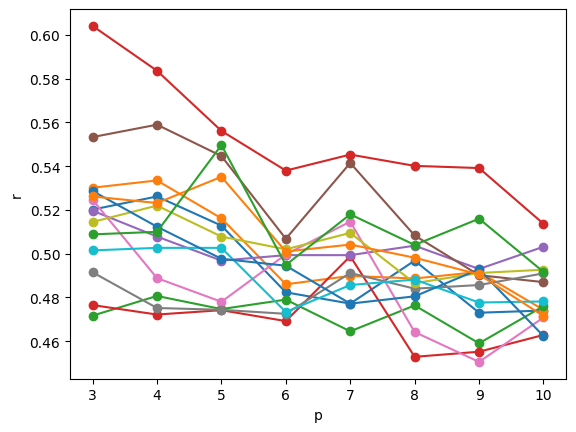

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
delta = results["Deltas"][0]
for i in range(results["sections"]):
    ax.plot(results["postprocessing"][delta].keys(), [results["postprocessing"][delta][p][i]["r"] for p in postprocessing[delta].keys()], marker="o")
ax.set_ylabel("r")

ax.set_xlabel("p")

In [ ]:
# backend_name = "iqm_garnet"
backend_name = "rigetti_ankaa_3"
extra = "_1"
nq = 5
results = np.load(f"./Data/{backend_name}/{nq}_1D{extra}.npy", allow_pickle=True).item()
task_load = AwsQuantumTask(arn=results["ids"][3])
metadata = task_load.metadata()
rigetti_results = task_load.result()
print(
        "The compiled circuit is:\n",
        rigetti_results.additional_metadata.rigettiMetadata.compiledProgram,
    )

circ_str = rigetti_results.additional_metadata.rigettiMetadata.compiledProgram
circ_str
# circ_str.count("ISWAP")

The compiled circuit is:
 PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[70]
PRAGMA PRESERVE_BLOCK
RZ(1.5707963267948966) 0
RZ(1.5707963267948966) 1
RZ(1.5707963267948966) 2
RZ(1.5707963267948966) 3
RZ(1.5707963267948966) 4
RZ(1.5707963267948966) 5
RZ(1.5707963267948966) 6
RZ(1.5707963267948966) 7
RZ(1.5707963267948966) 8
RZ(1.5707963267948966) 9
RZ(1.5707963267948966) 10
RZ(1.5707963267948966) 11
RZ(1.5707963267948966) 12
RZ(1.5707963267948966) 13
RZ(1.5707963267948966) 14
RZ(1.5707963267948966) 15
RZ(1.5707963267948966) 16
RZ(1.5707963267948966) 17
RZ(1.5707963267948966) 18
RZ(1.5707963267948966) 19
RZ(1.5707963267948966) 20
RZ(1.5707963267948966) 21
RZ(1.5707963267948966) 22
RZ(1.5707963267948966) 23
RZ(1.5707963267948966) 24
RZ(1.5707963267948966) 25
RZ(1.5707963267948966) 26
RZ(1.5707963267948966) 27
RZ(1.5707963267948966) 28
RZ(1.5707963267948966) 29
RZ(1.5707963267948966) 30
RZ(1.5707963267948966) 31
RZ(1.5707963267948966) 32
RZ(1.5707963267948966) 33
RZ(1.5707963267948966) 34
R

'PRAGMA INITIAL_REWIRING "NAIVE"\nDECLARE ro BIT[70]\nPRAGMA PRESERVE_BLOCK\nRZ(1.5707963267948966) 0\nRZ(1.5707963267948966) 1\nRZ(1.5707963267948966) 2\nRZ(1.5707963267948966) 3\nRZ(1.5707963267948966) 4\nRZ(1.5707963267948966) 5\nRZ(1.5707963267948966) 6\nRZ(1.5707963267948966) 7\nRZ(1.5707963267948966) 8\nRZ(1.5707963267948966) 9\nRZ(1.5707963267948966) 10\nRZ(1.5707963267948966) 11\nRZ(1.5707963267948966) 12\nRZ(1.5707963267948966) 13\nRZ(1.5707963267948966) 14\nRZ(1.5707963267948966) 15\nRZ(1.5707963267948966) 16\nRZ(1.5707963267948966) 17\nRZ(1.5707963267948966) 18\nRZ(1.5707963267948966) 19\nRZ(1.5707963267948966) 20\nRZ(1.5707963267948966) 21\nRZ(1.5707963267948966) 22\nRZ(1.5707963267948966) 23\nRZ(1.5707963267948966) 24\nRZ(1.5707963267948966) 25\nRZ(1.5707963267948966) 26\nRZ(1.5707963267948966) 27\nRZ(1.5707963267948966) 28\nRZ(1.5707963267948966) 29\nRZ(1.5707963267948966) 30\nRZ(1.5707963267948966) 31\nRZ(1.5707963267948966) 32\nRZ(1.5707963267948966) 33\nRZ(1.5707963267

In [ ]:
print(
        rigetti_results.additional_metadata.rigettiMetadata.compiledProgram[-1300:].split("\n"),
    )

['2724) 24', 'RX(1.5707963267948966) 24', 'PRAGMA END_PRESERVE_BLOCK', 'MEASURE 0 ro[0]', 'MEASURE 7 ro[10]', 'MEASURE 21 ro[20]', 'MEASURE 40 ro[39]', 'MEASURE 64 ro[54]', 'MEASURE 69 ro[64]', 'MEASURE 5 ro[11]', 'MEASURE 14 ro[19]', 'MEASURE 51 ro[40]', 'MEASURE 59 ro[53]', 'MEASURE 70 ro[65]', 'MEASURE 28 ro[30]', 'MEASURE 2 ro[2]', 'MEASURE 4 ro[4]', 'MEASURE 12 ro[6]', 'MEASURE 9 ro[8]', 'MEASURE 11 ro[14]', 'MEASURE 17 ro[16]', 'MEASURE 39 ro[22]', 'MEASURE 23 ro[26]', 'MEASURE 56 ro[32]', 'MEASURE 46 ro[35]', 'MEASURE 44 ro[37]', 'MEASURE 66 ro[42]', 'MEASURE 72 ro[44]', 'MEASURE 68 ro[47]', 'MEASURE 52 ro[49]', 'MEASURE 54 ro[51]', 'MEASURE 79 ro[56]', 'MEASURE 81 ro[62]', 'MEASURE 75 ro[69]', 'MEASURE 1 ro[1]', 'MEASURE 3 ro[3]', 'MEASURE 10 ro[7]', 'MEASURE 8 ro[9]', 'MEASURE 6 ro[12]', 'MEASURE 18 ro[15]', 'MEASURE 15 ro[18]', 'MEASURE 38 ro[23]', 'MEASURE 22 ro[27]', 'MEASURE 37 ro[31]', 'MEASURE 58 ro[34]', 'MEASURE 45 ro[36]', 'MEASURE 63 ro[38]', 'MEASURE 67 ro[41]', 'ME

In [ ]:
text = rigetti_results.additional_metadata.rigettiMetadata.compiledProgram[-1300:].split("\n")
meas = {}
for i in text:
    line = i.split()
    try:
        meas[int(line[1])] = int(line[2].split("[")[1][:-1])
    except:
        pass
meas

{0: 0,
 10: 10,
 20: 20,
 30: 30,
 58: 40,
 40: 50,
 68: 60,
 11: 9,
 19: 19,
 29: 29,
 57: 39,
 41: 49,
 69: 59,
 71: 69,
 5: 5,
 15: 15,
 23: 25,
 43: 35,
 39: 45,
 59: 55,
 65: 65,
 6: 6,
 16: 16,
 22: 26,
 50: 36,
 32: 46,
 60: 56,
 64: 66,
 1: 1,
 13: 7,
 9: 11,
 17: 17,
 27: 21,
 21: 27,
 31: 31,
 49: 37,
 51: 41,
 33: 47,
 47: 51,
 61: 57,
 67: 61,
 63: 67,
 2: 2,
 12: 8,
 8: 12,
 18: 18,
 26: 22,
 28: 28,
 38: 32,
 56: 38,
 44: 42,
 34: 48,
 54: 52,
 62: 58,
 74: 62,
 70: 68,
 3: 3,
 7: 13,
 25: 23,
 37: 33,
 45: 43,
 53: 53,
 73: 63,
 4: 4,
 14: 14,
 24: 24,
 36: 34,
 46: 44,
 52: 54,
 66: 64}

In [ ]:
qubits_in_line["rigetti_ankaa_3"]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 28,
 29,
 30,
 31,
 38,
 37,
 36,
 43,
 50,
 49,
 56,
 57,
 58,
 51,
 44,
 45,
 46,
 39,
 32,
 33,
 34,
 41,
 40,
 47,
 54,
 53,
 52,
 59,
 60,
 61,
 62,
 69,
 68,
 67,
 74,
 73,
 66,
 65,
 64,
 63,
 70,
 71,
 72,
 79,
 78,
 77]

In [ ]:
results["GT"].nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 13, 12, 11, 10, 9, 8, 7, 14, 15, 16, 17, 18, 19, 20, 27, 26, 25, 24, 23, 22, 21, 28, 29, 30, 31, 38, 37, 36, 43, 50, 49, 56, 57, 58, 51, 44, 45, 46, 39, 32, 33, 34, 41, 40, 47, 54, 53, 52, 59, 60, 61, 62, 69, 68, 67, 74, 73, 66, 65, 64, 63, 70, 71))

In [ ]:
GT.edges()

EdgeView([(0, 1), (1, 2), (2, 3), (3, 4)])

In [ ]:
sorted(meas.keys())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 31,
 32,
 33,
 34,
 37,
 38,
 39,
 40,
 44,
 45,
 46,
 47,
 51,
 52,
 53,
 54,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 78,
 79,
 80,
 81]

In [ ]:
sorted(meas.values())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69]